In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.stats import norm

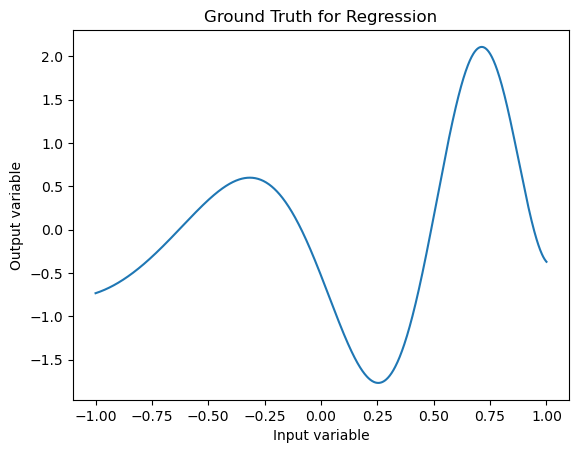

In [2]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return np.cos( 0.1*x**2 + 0.01*x - 1 ) + np.exp(0.1*x)

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(5*xs + 5)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

In [110]:
def plot_bnn_predictive_distribution(bnn_model, x_tr, y_tr, num_samps=1000):
    # Generate input data points for prediction
    xs = np.linspace(-1, 1, 500)

    alpha_values = np.array([0.005, 0.05, 0.5]) #ALPHA VALUES
    alpha_colours = ["#9cbcf0","#5f85c2","#144491"] #COLOURS OF THE INSIDE OF BANDS

    # Get predictions from the BNN model
    preds = bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps)[0].squeeze(-1).detach().numpy()
    
    # Calculate mean and standard deviation of predictions
    pred_mean = preds.mean(0)
    pred_std = preds.std(0)
    index = 0
    # Plot the predictive mean and confidence intervals
    plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
   
    for alpha in alpha_values:
        plt.fill_between(xs, np.quantile(preds, 1 - alpha / 2, axis=0), np.quantile(preds, alpha / 2, axis=0), color =  alpha_colours[index],alpha=0.4, label=f'{(1-alpha)*100}% CI')
        # COLOUR OF LINES BETWEEN BANDS GOES BELOW                     !!!!!!!
        plt.plot(xs, np.quantile(preds, 1 - alpha / 2, axis=0), color="#0b254f", label='', lw = 0.4)
        #                                                          !!!!!!!!!!
        plt.plot(xs, np.quantile(preds, alpha / 2, axis=0), color="#0b254f", label='', lw = 0.4)
        index += 1


    # Plot the ground truth (assuming the function normalised_ground_truth is defined)
    ys = normalised_ground_truth(xs)
    plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
    
    # Plot the observed data points
    #plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
    
    # Add title and legend
    plt.title("BNN Predictive Distribution vs Ground Truth", fontsize=18)
    plt.legend(fontsize=10, loc='upper left')
    
    # Set plot limits and customize ticks
    plt.xlim([-1, 1])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    # Display the plot
    plt.show()

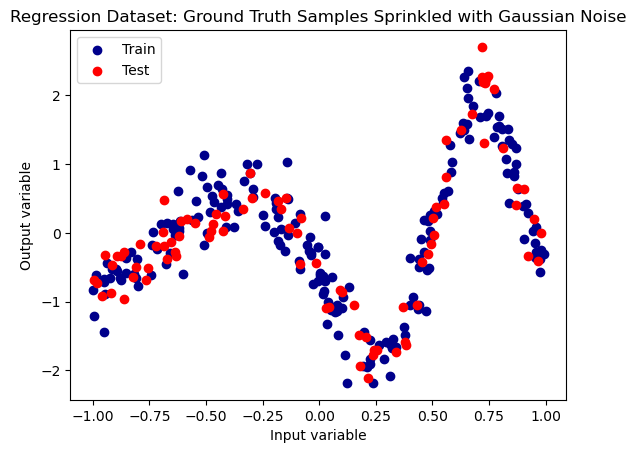

In [5]:
def gen_gaussian_noise(size=100, noise=0.5, test_size=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=test_size)

np.random.seed(201)

x_tr, x_te, y_tr, y_te = gen_gaussian_noise(size=300, noise=0.3, test_size = 0.3)
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

In [22]:
class GaussianMeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=0.05, prior_var=1):
        super(GaussianMeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))

        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    # def kl(self):
    #     weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
    #     bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
    #     return weight_kl + bias_kl
    def kl(self, param_sample):
        weights = param_sample[0]
        biases = param_sample[1]
        weight_kl = self.q_w().log_prob(weights) - self.p_w().log_prob(weights)
        bias_kl = self.q_b().log_prob(biases) - self.p_b().log_prob(biases)
        return weight_kl.sum(dim=[1,2]).mean(0) + bias_kl.sum(dim=[1,2]).mean(0)



    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        # print('dim weights', weights.shape)

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        # print('dim biases', biases.shape)
        # print('dim x', x.shape)
        # print('dim x @ weights', (x @ weights).shape)
        
        # print('dim x @ weights + biases', (x @ weights + biases).shape)
        return x @ weights + biases, [weights, biases] # (num_samples, batch_size, output_dim).




class GaussianMeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.ELU(),
        noise_std = 1.0,
        prior_var = 1
    ):
        super(GaussianMeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        
        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(GaussianMeanFieldLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    GaussianMeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                )
            else:
                self.network.append(
                    GaussianMeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."
        param_samples = []
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for layer in self.network:
            if isinstance(layer, GaussianMeanFieldLayer):
                x, param_sample = layer(x)
                param_samples.append(param_sample)
            else:
                x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x, param_samples

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self,param_samples):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl(param_samples[i//2]) for i, layer in enumerate(self.network) if isinstance(layer, GaussianMeanFieldLayer)])


    # def loss(self, x, y, num_samples=1):
    #     """Computes the ELBO and returns its negative"""

    #     y_pred = self.forward(x, num_samples=num_samples)
        
    #     exp_ll = self.ll(y, y_pred, num_samples=num_samples)
    #     kl = self.kl()

    #     return kl - exp_ll, exp_ll, kl
    
    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred, param_samples = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl(param_samples)

        return kl - exp_ll, exp_ll, kl


In [38]:
gaussian_bnn_model = GaussianMeanFieldBNN(1, [10, 10], 1, noise_std=0.3, prior_var = 0.4)


g_opt = torch.optim.Adam(
    gaussian_bnn_model.parameters(),
    lr = 1e-1
)

# ExponentialLR schedulers for each optimizer
gamma = 0.999  # You can adjust this value as needed


g_scheduler = torch.optim.lr_scheduler.ExponentialLR(g_opt, gamma=gamma)


100%|██████████| 4000/4000 [01:19<00:00, 50.19it/s]


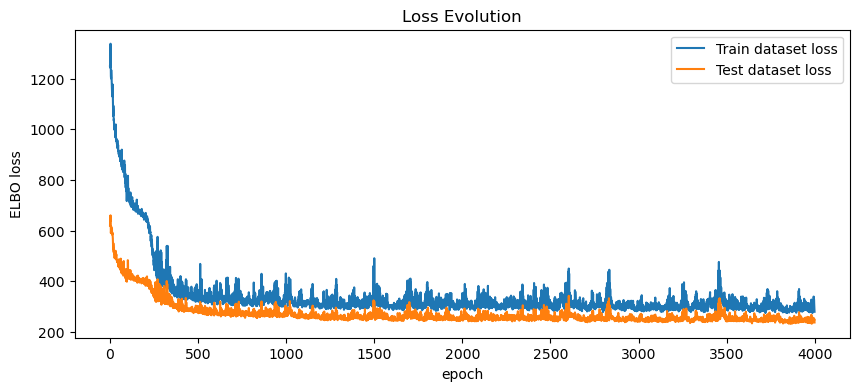

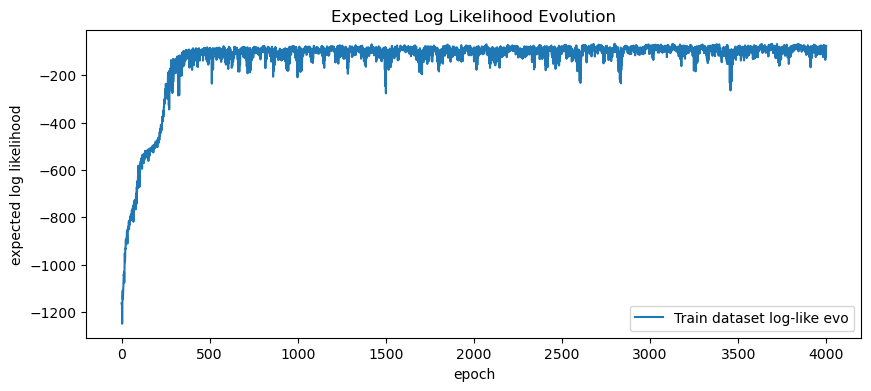

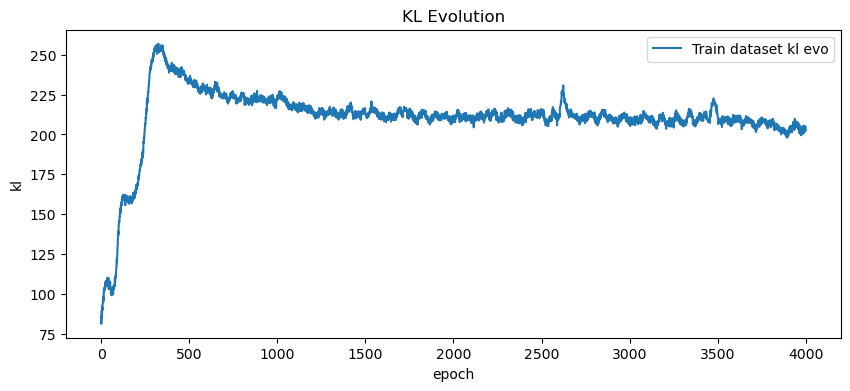

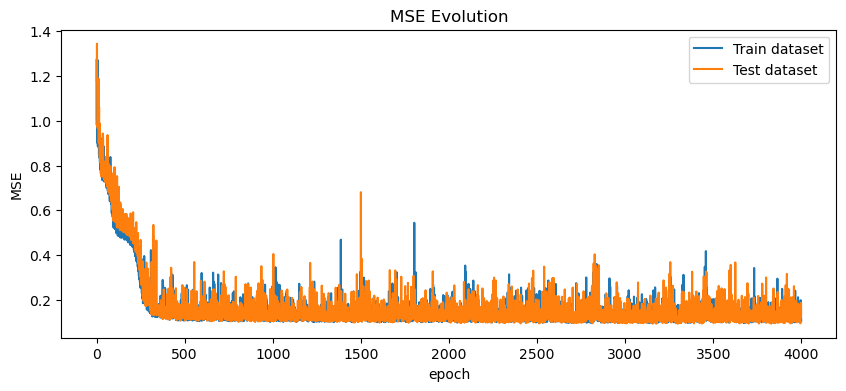

In [39]:
# Train Gaussian
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []
tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

epochs = 4000 


for epoch in tqdm(range(epochs)):  # epochs
    g_opt.zero_grad()

    l, ll, kl = gaussian_bnn_model.loss(x_tr, y_tr, num_samples = 20)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(gaussian_bnn_model(x_tr)[0], y_tr.unsqueeze(0)).item())

    te_loss_evo.append(gaussian_bnn_model.loss(x_te, y_te,num_samples=20)[0].item())
    te_mse_loss_evo.append(aux_loss(gaussian_bnn_model(x_te)[0], y_te.unsqueeze(0)).item())

    l.backward()
    g_opt.step()


plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

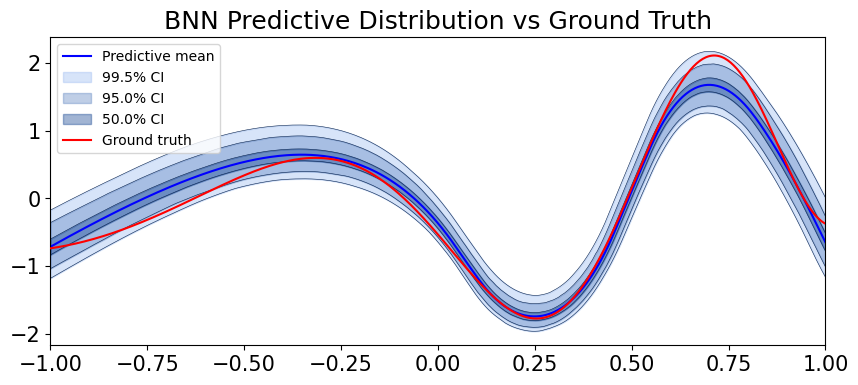

In [111]:
plot_bnn_predictive_distribution(gaussian_bnn_model, x_tr, y_tr)

In [ ]:
alpha_values = np.arange(0.01, 1.0, 0.01)
num_samples = 1000  # BNN posterior samples
mseloss = nn.MSELoss()
noise = 0.3
x_te_dense = torch.FloatTensor(np.linspace(-1, 1, 1000)).unsqueeze(-1)
true_mean = normalised_ground_truth(x_te_dense)  # True function values
posterior_samples_gauss  = gaussian_bnn_model(x_te_dense, num_samples)[0].detach().numpy()  # Shape: (num_samples, 1000)
for alpha in alpha_values:

    lower_bounds_gauss = np.quantile(posterior_samples_gauss, alpha / 2, axis=0)
    upper_bounds_gauss = np.quantile(posterior_samples_gauss, 1 - alpha / 2, axis=0)


lower_bounds_gauss.shape
for i in range(10):
    print("[",lower_bounds_gauss[i,0],",",upper_bounds_gauss[i,0],"]")

[ -0.713325914144516 , -0.708935693204403 ]
[ -0.7070011964440346 , -0.702526144683361 ]
[ -0.7007095965743065 , -0.696155480146408 ]
[ -0.6944578316807747 , -0.6898209625482559 ]
[ -0.6881617721915245 , -0.6835821914672852 ]
[ -0.6818025836348534 , -0.6773351806402207 ]
[ -0.6753067538142205 , -0.671095375418663 ]
[ -0.668869900405407 , -0.6648617148399353 ]
[ -0.6624401453137397 , -0.6586607968807221 ]
[ -0.6560694128274918 , -0.6524827462434769 ]


In [47]:
lower_bounds_gauss.shape

(1000, 1)